# Caltech UCSD Birds 200 2011 (CUB-200-2011)

## Part 5A - Extracting the output layer activations.

The previous notebooks showed how to train a ResNet 152 model which had been initialised with pre-trained weights from ImageNet, for the task of fine grained image classification of bird species using the CUB-200-2011 dataset, and evaluate its performance by investigating the class accuracy of each class of birds.

This notebook shows how to extract the activations of the final layer of the model that ouput to the linear classifier of our ResNet 152 model trained on the CUB-200-2011 dataset, to further investigate in Part 5B on how well our model is performing with the given dataset.

This is the fifth stage of our roadmap for building and understanding a birds image classifier:

![RoadMapImage](../docs/birds_roadmap.png)

This notebook will show in detail:

    1. Setting up of an evaluation of the test image set (like in the fourth stage).
    
    2. The use of "hooks" to get outputs from the neural network at intermediate (or hidden) layers within the network.
    
    3. Cataloguing and saving of these layer outputs for further investigations.

## Notebook setup

### Modules and externals

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms
from cub_tools.data import ImageFolderWithPaths
from cub_tools.layer_feature_maps import extract_feature_maps

### Runtime setup

In [2]:
# Script runtime options
root_dir = '..'  #'/home/jupyter/caltech_birds'
model = 'resnet152'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

## Dataloaders, Device setup and load model

As before, we setup the dataloaders and transformations for feeding into the neural network.

As with the evaluation phase, in this example, we only need to load the test image dataset, as we are loading the pre-trained model from the previous network.

After that we setup the device to be used for computation of the results and we load the trained model, as before a ResNet 152.

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms(img_crop_size=224, img_resize=256)

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: ImageFolderWithPaths(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


In [7]:
# Load the best model from file
model_ = torch.load(model_file)

In [8]:
model_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Feature activations extraction

In this part, we append a special function, called a hook, to the layer that we want to get the outputs from. In this case, we are interested in the inputs into the final classification layer (FC), which we can see from the above output of the model structure is called average pool (avgpool). The function we are using simply appends the output of this layer to specified list **fc_feature_extractions**. During the testing process, for each image, the output of this layer will be appended to the aforementioned list. We know that the linear classifier layer (FC) has an input size of 2048, so our expectation is that we will have a list of length number of test images, with each list entry having a vector of length 2048, which are the final layer neuron activations. These are the "barcode" that the final classifier layer learns to interpret as being indicative of the image class, that is, the bird species contained in the image.

The below code blocks show the simple hook function, the appending of this hook to the avgpool layer, and the execution of model evaluation using the test image set.

Finally we save to disk (pickle) the returned dictionary from the feature extractions process which contains the final layer activations, and the true and predicted classes for each test image.

In [9]:
fc_feature_extractions= []
def hook(module, input, output):
    fc_feature_extractions.append(output)

In [10]:
#model_.fc.register_forward_hook(hook)
model_.avgpool.register_forward_hook(hook)

In [11]:
feature_extractions_dict = extract_feature_maps(model=model_, dataloader=dataloaders['test'], fc_feature_extractions=fc_feature_extractions,device=device)

Commencing predictions and feature extraction minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..1450..1475..1500..1525..1550..1575..1600..1625..1650..1675..1700..1725..1750..1775..1800..1825..1850..1875..1900..1925..1950..1975..2000..2025..2050..2075..2100..2125..2150..2175..2200..2225..2250..2275..2300..2325..2350..2375..2400..2425..2450..2475..2500..2525..2550..2575..2600..2625..2650..2675..2700..2725..2750..2775..2800..2825..2850..2875..2900..2925..2950..2975..3000..3025..3050..3075..3100..3125..3150..3175..3200..3225..3250..3275..3300..3325..3350..3375..3400..3425..3450..3475..3500..3525..3550..3575..3600..3625..3650..3675..3700..3725..3750..3775..3800..3825..3850..3875..3900..3925..3950..3975..4000..4025..4050..4075..4100

In [12]:
save_pickle(feature_extractions_dict, '../models/classification/{}/{}_feature_extractions.pkl'.format(model,model))

In [13]:
feature_extractions_dict['feature extractions'][0].shape

(1, 2048, 1, 1)

## Visualising an activation vector

What do the activation vectors contain?

From the plot below we can see we have a vector of 2048 floats, with varying degrees of magnitude. This is the "barcode", the distinctive patterns of activations that the linear classifier learns to predict the probabilities of each species of bird from the input image. Hopefully, it does this well enough to prove useful and accurate for the task in hand.

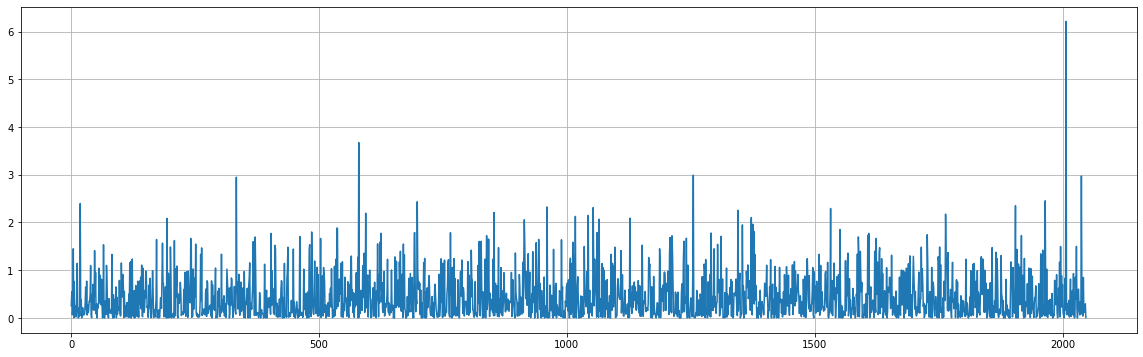

In [14]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,feature_extractions_dict['feature extractions'][0].shape[1],1),
         feature_extractions_dict['feature extractions'][0].ravel())
plt.grid(True)
plt.show()